In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm
from sklearn import datasets

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [3]:
# np.random.seed(249)
# xx, y = datasets.make_circles(n_samples=300, factor=0.5, noise=0.05)
# x_ = np.random.randn(100, 2)*0.1
# xx = np.concatenate([xx, x_], axis=0)
# y = np.concatenate([y, np.ones(len(x_), dtype=int)*0])

In [4]:
np.random.seed(249) ## 148, 249

xxc, yc = datasets.make_circles(n_samples=265, factor=.5,
                                      noise=.07)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

In [5]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([100, 100, 100]))

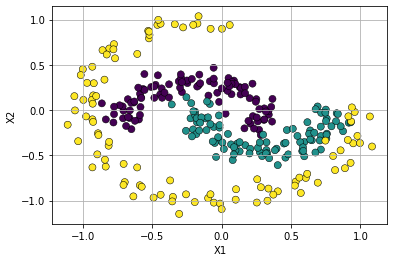

In [6]:
## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
# x1 = (x1-x1.min())/(x1.max()-x1.min())
# x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

xx = torch.Tensor(xx)
yy = torch.Tensor(y.reshape(-1, 1))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

# (x1min, x1max) = -0.1, 1.1
# plt.xlim((x1min, x1max))
# plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [7]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         init_val = torch.ones(num_sets, output_dim)/output_dim

        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 1.
        self.cls_weight = nn.Parameter(init_val.abs())

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data.abs_()
#         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = self.cls_weight
        c = torch.softmax(self.cls_weight, dim=1)
        return x@c

In [8]:
# class LeakySignum(nn.Module):
#     def forward(self, x):
#         x=x+0.5
#         o1x = 0.1*x
#         return torch.minimum(torch.maximum(x, o1x*0.0), o1x+0.9)

In [9]:
class LeakyRectFilter(nn.Module):
    def forward(self, x):
        x = x.abs()
#         return -torch.maximum(torch.minimum(0.1*x-0.15, x-1.5), 0.1*x-1.05)
        return -torch.maximum(torch.minimum(0.01*(x-1.5), x-1.5), 0.1*x-1.05)

## Train, non-softmax based classifier


In [10]:
#### if we use same distance scaler, then same always increasing function, we get same argmax db

In [11]:
class LeakySignum(nn.Module):
    def forward(self, x):
        o1x = 0.1*x
        return torch.minimum(torch.maximum(x, o1x), o1x+0.9)

In [12]:
class DistanceBinaryClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        self.actf = nn.Sigmoid()
#         self.actf = LeakySignum()
#         self.actf = LeakyRectFilter()
        self.pos_val = nn.Parameter(torch.ones(1, output_dim)*0.5)
        self.neg_val = nn.Parameter(torch.ones(1, output_dim)*0.5)
        
    def forward(self, x, hard=False):
        self.pos_val.data.abs_()
        self.pos_val.data = self.pos_val.data/self.pos_val.data.sum()
        self.neg_val.data.abs_()
        self.neg_val.data = self.neg_val.data/self.neg_val.data.sum()
        
        x = torch.norm(x-self.centers, dim=1, keepdim=True) + self.bias
        if hard:
            x = torch.sigmoid(-x*1e5)
        else:
            x = self.actf(-x*self.inv_temp)
        x = x*self.pos_val + (1-x)*self.neg_val
        return x

In [13]:
class DistanceMulticlassClassifier(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1, num_sets)*-1)
        self.inv_temp = nn.Parameter(torch.ones(1, num_sets)*inv_temp)
        
#         init_val = torch.ones(num_sets, output_dim)/output_dim
        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 1.
        self.cls_weight = nn.Parameter(init_val.abs())

        self.cls_confidence = None
        self.dist_loss = 0
        
#         self.actf = nn.Sigmoid()
        self.actf = LeakySignum()
#         self.actf = LeakyRectFilter()
        
    def forward(self, x, hard=False):
#         self.cls_weight.data.abs_()
#         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
#         dists = dists*self.inv_temp + self.bias
        dists = dists + self.bias

#         if hard:
        dists = self.actf(-dists)
        indices = torch.argmax(dists, dim=1)
        c = torch.softmax(self.cls_weight, dim=1)

        probs = c[indices]
        scaler = dists[torch.arange(len(indices), dtype=torch.long), indices]
#         print(scaler)
#         print(probs)

        x = torch.softmax(dists, dim=1)
        y = probs*scaler.reshape(-1, 1)
    
        self.cls_confidence = scaler.data
#         self.dist_loss = -torch.cdist(x, self.centers).mean()
#         return x@c
        return y

In [14]:
dmc = DistanceMulticlassClassifier(2, 5, 3)

In [15]:
dmc(torch.randn(10, 2))

tensor([[ 1.1342e-01,  4.3183e-02,  4.5401e-02],
        [ 3.3450e-01,  1.2736e-01,  1.3390e-01],
        [-6.2915e-04, -2.3339e-04, -2.5154e-04],
        [ 4.4535e-01,  1.6956e-01,  1.7827e-01],
        [ 4.1629e-01,  1.5443e-01,  1.6644e-01],
        [ 5.3809e-01,  2.0488e-01,  2.1540e-01],
        [ 1.6454e-01,  6.2646e-02,  6.5864e-02],
        [ 3.8133e-01,  1.4519e-01,  1.5265e-01],
        [ 7.7292e-02,  8.3886e-02,  2.0532e-01],
        [ 1.6432e-01,  3.8952e-01,  1.4739e-01]], grad_fn=<MulBackward0>)

In [16]:
dmc.cls_confidence

tensor([ 0.2020,  0.5958, -0.0011,  0.7932,  0.7372,  0.9584,  0.2930,  0.6792,
         0.3665,  0.7012])

In [17]:
ycls = yy.reshape(-1).type(torch.long)

ycls_ = torch.zeros(len(ycls), ycls.max()+1)
ycls_[torch.arange(0, len(ycls), dtype=torch.long), ycls] = 1.

In [18]:
# ycls_, ycls

In [19]:
# model = nn.Sequential(nn.Linear(2, 10, bias=False),
# #                       nn.BatchNorm1d(10),
#                       nn.SELU(),
#                       nn.Linear(10, 2, bias=False),
# #                       nn.BatchNorm1d(2),
#                       nn.SELU(),
#                      )

In [20]:
actf = irf.Swish
# actf = irf.ReLU
flows = [
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
        ]

model = nn.Sequential(*flows)

In [21]:
# classifier = ConnectedClassifier_SoftKMeans(2, 5, ycls.max().item()+1, inv_temp=1)
# classifier = DistanceBinaryClassifier(2, ycls.max().item()+1, inv_temp=1)
classifier = DistanceMulticlassClassifier(2, 5, ycls.max().item()+1)

In [22]:
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=0.001)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  432


In [ ]:
%matplotlib tk
fig = plt.figure(figsize=(12, 6))
ax, ax_ = fig.subplots(1, 2)

model.train()
losses = []
NUM = 512

### for plotting in 2d grid
ng = 400
# _a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
s = 1.0
_a,_b,_c,_d = x1.min()-s, x1.max()+s, x2.min()-s, x2.max()+s
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

for epoch in tqdm(range(1000*10+1)):
    optimizer.zero_grad()
    
    z = model(xx)
    yout = classifier(z)
    
    loss = criterion(yout, ycls_) #+ classifier.dist_loss*0.001
#     loss = criterion(yout, ycls)
    loss.backward()
    optimizer.step()
        
    if epoch%100 == 0:
        acc = (yout.data.argmax(dim=1) == ycls)
        acc = float(acc.type(torch.float32).mean())
        losses.append(float(loss))
        print(f"Epoch: {epoch} Loss: {losses[-1]} Accuracy: {acc}")

        ax.clear(); ax_.clear()
        with torch.no_grad():
            z = model(xx)
            yout = classifier(z)
            
        yout_img = classifier(model(xyg))
        out = yout_img.data.argmax(dim=1).numpy()
#         out = yout_img.data[torch.arange(0, len(out), dtype=torch.long), out.reshape(-1)].numpy()

        cf = ax.contourf(xg, yg, out.reshape(xg.shape),# v,
                         alpha=0.5, antialiased=True)

        cf = ax_.contourf(xg, yg, classifier.cls_confidence.reshape(xg.shape),
                         alpha=0.5, antialiased=True, levels=15)
        ax.grid()

        ax_.scatter(x1, x2, c=ycls.numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=ycls.numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
#         ax.scatter(x1, x2, c=yout.data.argmax(dim=1).numpy().reshape(-1), marker='.')
            
        fig.canvas.draw()
        plt.savefig("./03.3_ood_3moons.png")
        plt.pause(0.01)
plt.close()

  0%|          | 0/10001 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.2631407082080841 Accuracy: 0.4866666793823242


  1%|          | 88/10001 [00:01<01:27, 112.90it/s]

Epoch: 100 Loss: 0.1960197240114212 Accuracy: 0.5266666412353516


  2%|▏         | 191/10001 [00:02<01:24, 115.83it/s]

Epoch: 200 Loss: 0.171844482421875 Accuracy: 0.6233333349227905


  3%|▎         | 295/10001 [00:04<01:23, 116.29it/s]

Epoch: 300 Loss: 0.14001718163490295 Accuracy: 0.7266666889190674


  4%|▍         | 398/10001 [00:05<01:21, 118.28it/s]

Epoch: 400 Loss: 0.13286398351192474 Accuracy: 0.7366666793823242


  5%|▍         | 487/10001 [00:06<01:27, 108.82it/s]

Epoch: 500 Loss: 0.12192802131175995 Accuracy: 0.7599999904632568


  6%|▌         | 591/10001 [00:07<01:20, 116.33it/s]

Epoch: 600 Loss: 0.11299661546945572 Accuracy: 0.7799999713897705


  7%|▋         | 692/10001 [00:09<01:19, 116.40it/s]

Epoch: 700 Loss: 0.0824352577328682 Accuracy: 0.8600000143051147


  8%|▊         | 793/10001 [00:10<01:19, 116.38it/s]

Epoch: 800 Loss: 0.07692042738199234 Accuracy: 0.8666666746139526


  9%|▉         | 896/10001 [00:11<01:17, 117.71it/s]

Epoch: 900 Loss: 0.07698124647140503 Accuracy: 0.8633333444595337


 10%|▉         | 999/10001 [00:13<01:17, 115.77it/s]

Epoch: 1000 Loss: 0.0729607418179512 Accuracy: 0.8700000047683716


 11%|█         | 1096/10001 [00:14<01:20, 111.08it/s]

Epoch: 1100 Loss: 0.07372892647981644 Accuracy: 0.8666666746139526


 12%|█▏        | 1193/10001 [00:15<01:20, 109.68it/s]

Epoch: 1200 Loss: 0.06678921729326248 Accuracy: 0.8833333253860474


 13%|█▎        | 1289/10001 [00:17<01:20, 108.73it/s]

Epoch: 1300 Loss: 0.06252003461122513 Accuracy: 0.8899999856948853


 14%|█▍        | 1399/10001 [00:18<01:13, 116.61it/s]

Epoch: 1400 Loss: 0.06078428775072098 Accuracy: 0.8933333158493042


 15%|█▍        | 1496/10001 [00:20<01:16, 110.51it/s]

Epoch: 1500 Loss: 0.0540447011590004 Accuracy: 0.9066666960716248


 16%|█▌        | 1593/10001 [00:21<01:16, 109.54it/s]

Epoch: 1600 Loss: 0.052129048854112625 Accuracy: 0.9100000262260437


 17%|█▋        | 1691/10001 [00:22<01:16, 108.37it/s]

Epoch: 1700 Loss: 0.045002277940511703 Accuracy: 0.9233333468437195


 18%|█▊        | 1800/10001 [00:24<01:11, 114.06it/s]

Epoch: 1800 Loss: 0.0454847514629364 Accuracy: 0.9233333468437195


 19%|█▉        | 1895/10001 [00:25<01:17, 104.59it/s]

Epoch: 1900 Loss: 0.04377063363790512 Accuracy: 0.9266666769981384


 20%|█▉        | 1990/10001 [00:27<01:16, 104.26it/s]

Epoch: 2000 Loss: 0.04204423725605011 Accuracy: 0.9300000071525574


 21%|██        | 2100/10001 [00:28<01:07, 117.28it/s]

Epoch: 2100 Loss: 0.03872271254658699 Accuracy: 0.9366666674613953


 22%|██▏       | 2197/10001 [00:30<01:11, 108.90it/s]

Epoch: 2200 Loss: 0.04018519073724747 Accuracy: 0.9333333373069763


 23%|██▎       | 2293/10001 [00:31<01:09, 110.89it/s]

Epoch: 2300 Loss: 0.03833504021167755 Accuracy: 0.9366666674613953


 24%|██▍       | 2389/10001 [00:32<01:12, 105.56it/s]

Epoch: 2400 Loss: 0.04412420839071274 Accuracy: 0.9266666769981384


 25%|██▍       | 2495/10001 [00:34<01:06, 113.62it/s]

Epoch: 2500 Loss: 0.031531307846307755 Accuracy: 0.949999988079071


 26%|██▌       | 2591/10001 [00:35<01:06, 110.73it/s]

Epoch: 2600 Loss: 0.032955434173345566 Accuracy: 0.9466666579246521


 27%|██▋       | 2689/10001 [00:36<01:05, 111.16it/s]

Epoch: 2700 Loss: 0.030801929533481598 Accuracy: 0.949999988079071


 28%|██▊       | 2800/10001 [00:38<01:01, 117.00it/s]

Epoch: 2800 Loss: 0.03434184938669205 Accuracy: 0.9433333277702332


 29%|██▉       | 2897/10001 [00:39<01:04, 109.75it/s]

Epoch: 2900 Loss: 0.022020189091563225 Accuracy: 0.9633333086967468


In [ ]:
yout

In [ ]:
model.eval()
%matplotlib inline

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

with torch.no_grad():
    z = model(xyg)
    y = torch.argmax(classifier(z, hard=True), dim=1)
    
cf = plt.contourf(xg, yg, y.reshape(xg.shape),# v,
                     alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, marker='o', c=yy.reshape(-1))

In [ ]:
plt.scatter(z[:,0], z[:,1], marker='.', c=y.reshape(-1))   